<a href="https://colab.research.google.com/github/vicky2000-hub/test1/blob/main/Workbook_Malicious_URL_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for Security Analysts - Workbook </br> Malicious URL Predictor

---


Author: GTKlondike
</br>
Email: GTKlondike@gmail.com
</br>
YouTube: [NetSec Explained](https://www.youtube.com/channel/UCsKK7UIiYqvK35aWrCCgUUA)

**Dataset:** https://github.com/NetsecExplained/Machine-Learning-for-Security-Analysts

**Goal:** This workbook will walk you through the steps to build, train, test, and evaluate a malicious URL predictor using the Scikit-learn machine learning library

**Outline:** 
* Initial Setup
* Tokenization
* Load Training Data
* Vectorize Training Data
* Load Testing Data
* Train and Evaluate Models


## Instructions
To use Jupyter notebooks:
* To run a cell, click on the play button to the left of the code or pressh shift+enter
* You will see a busy indicator in the top left area while the runtime is executing
* A number will appear when the cell is done

# Initial Setup
We'll start by downloading the data and loading the needed libraries.

In [16]:
# Download data from Github
! git clone https://github.com/NetsecExplained/Machine-Learning-for-Security-Analysts.git
  
# Install dependencies
! pip install nltk sklearn pandas matplotlib seaborn
data_dir = "Machine-Learning-for-Security-Analysts/Malicious URLs.csv"

fatal: destination path 'Machine-Learning-for-Security-Analysts' already exists and is not an empty directory.


In [17]:
# Common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import re

%matplotlib inline

# Import Scikit-learn helper functions
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Import Scikit-learn models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Import Scikit-learn metric functions
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns



print("\n### Libraries Imported ###\n")


### Libraries Imported ###



# Load the dataset
With this set, we first need to load our CSV data.

In [18]:
# Load the training data
print("- Loading CSV Data -")
url_df = pd.read_csv(data_dir)

test_url = url_df['URLs'][4]

print("\n### CSV Data Loaded ###\n")

- Loading CSV Data -

### CSV Data Loaded ###



In [19]:
# Let's see what our training data looks like
print(url_df)

                                                     URLs Class
0                         freebase.com/view/en/bob_sirois  good
1                          en.wikipedia.org/wiki/Joie_Lee  good
2                pipl.com/directory/people/Rejean/Beaudin  good
3       flickr.com/photos/teneyck/sets/72157610336209297/  good
4       ussoccer.com/News/Federation-Services/2009/06/...  good
...                                                   ...   ...
420459  ourorigins.org/genealogielistfirstname.aspx?an...  good
420460    simira.co.id/cifk/live.com/Account_Verified.htm   bad
420461  kstatesports.com/sports/w-baskbl/spec-rel/ksu-...  good
420462  vh1.com/video/living-colour/9128/cult-of-perso...  good
420463     absoluteastronomy.com/topics/SummerSlam_(1990)  good

[420464 rows x 2 columns]


In [20]:
# Perform Train/Test split
test_percentage = .2

train_df, test_df = train_test_split(url_df, test_size=test_percentage, random_state=42)

labels = train_df['Class']
test_labels = test_df['Class']

print("\n### Split Complete ###\n")


### Split Complete ###



- Counting Splits -
Training Samples: 336371
Testing Samples: 84093


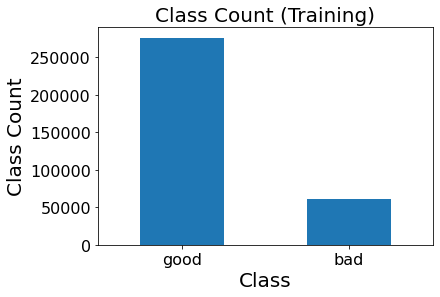

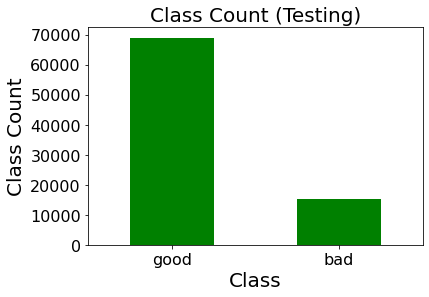

In [21]:
# Print counts of each class
print("- Counting Splits -")
print("Training Samples:", len(train_df))
print("Testing Samples:", len(test_df))

# Graph counts of each class, for both training and testing
count_train_classes = pd.value_counts(train_df['Class'])
count_train_classes.plot(kind='bar', fontsize=16)
plt.title("Class Count (Training)", fontsize=20)
plt.xticks(rotation='horizontal')
plt.xlabel("Class", fontsize=20)
plt.ylabel("Class Count", fontsize=20)

plt.show()

count_test_classes = pd.value_counts(test_df['Class'])
count_test_classes.plot(kind='bar', fontsize=16, colormap='ocean')
plt.title("Class Count (Testing)", fontsize=20)
plt.xticks(rotation='horizontal')
plt.xlabel("Class", fontsize=20)
plt.ylabel("Class Count", fontsize=20)

plt.show()

# Tokenization
Create our tokenizer by splitting URLs into their domains, subdomains, directories, files, and extensions.

In [22]:
# Define tokenizer
#   The purpose of a tokenizer is to separate the features from the raw data


def tokenizer(url):
  """Separates feature words from the raw data
  Keyword arguments:
    url ---- The full URL
    
  :Returns -- The tokenized words; returned as a list
  """
  
  # Split by slash (/) and dash (-)
  tokens = re.split('[/-]', url)
  
  for i in tokens:
    # Include the splits extensions and subdomains
    if i.find(".") >= 0:
      dot_split = i.split('.')
      
      # Remove .com and www. since they're too common
      if "com" in dot_split:
        dot_split.remove("com")
      if "www" in dot_split:
        dot_split.remove("www")
      
      tokens += dot_split
      
  return tokens
    
print("\n### Tokenizer defined ###\n")


### Tokenizer defined ###



## Task 1 - Tokenize a URL
1. Print the full URL, **test_url**
2. Print the results of **tokenizer(test_url)**

In [23]:
# Let's see how our tokenizer changes our URLs

print("\n- Full URL -\n")
# (Write code here)
print(test_url)



# Tokenize test URL
print("\n- Tokenized Output -\n")
# (Write code here)
tokenized_url = tokenizer(test_url)
print(tokenized_url)


- Full URL -

ussoccer.com/News/Federation-Services/2009/06/University-Of-Miami-President-Donna-E-Shalala-Joins-Team-To-Bring-FIFA-World-Cup-To-United-States-In.aspx

- Tokenized Output -

['ussoccer.com', 'News', 'Federation', 'Services', '2009', '06', 'University', 'Of', 'Miami', 'President', 'Donna', 'E', 'Shalala', 'Joins', 'Team', 'To', 'Bring', 'FIFA', 'World', 'Cup', 'To', 'United', 'States', 'In.aspx', 'ussoccer', 'In', 'aspx']


# Vectorize the Data
Now that the training data has been loaded, we'll train the vectorizers to turn our features into numbers.

## Task 2 - Train the vectorizers
1. Create the count vectorizer **cVec** using the **CountVectorizer** function
2. Configure *cVec* to use the *tokenizer* function from earlier
3. Perform **fit_transform** on *cVec* to train the vectorizer with the *training URLs*\
a. Save the result as **count_X**


4. Create the TF-IDF vectorizer **tVec** using the **TfidfVectorizer** function
5. Configure *tVec* to use the *tokenizer* function from earlier
6. Perform **fit_transform** on *tVec* to train the vectorizer with the *training URLs*\
a. Save the result as **tfidf_X** 

In [24]:
# Vectorizer the training inputs -- Takes about 30 seconds to complete
#   There are two types of vectors:
#     1. Count vectorizer
#     2. Term Frequency-Inverse Document Frequency (TF-IDF)

print("- Training Count Vectorizer -")
# (Write code here)
cVec = CountVectorizer(tokenizer= tokenizer)
count_X = cVec.fit_transform(train_df['URLs'])



print("- Training TF-IDF Vectorizer -")
# (Write code here)

tVec = TfidfVectorizer(tokenizer= tokenizer)
tfidf_X = tVec.fit_transform(train_df['URLs'])

# (Keep the following lines)
print("\n### Vectorizing Complete ###\n")

- Training Count Vectorizer -
- Training TF-IDF Vectorizer -

### Vectorizing Complete ###



## Task 2a (optional) - Count the test URL tokens
1. Print the count of each *token* from **test_url**

In [25]:
# Manually perform term count on test_url
# (Write code here)

for token in list(dict.fromkeys(tokenized_url)):
  print("{} - {}".format(tokenized_url.count(token),token))


1 - ussoccer.com
1 - News
1 - Federation
1 - Services
1 - 2009
1 - 06
1 - University
1 - Of
1 - Miami
1 - President
1 - Donna
1 - E
1 - Shalala
1 - Joins
1 - Team
2 - To
1 - Bring
1 - FIFA
1 - World
1 - Cup
1 - United
1 - States
1 - In.aspx
1 - ussoccer
1 - In
1 - aspx


## Task 2b (optional) - View the test URL vectorizers
1. Create a new **CountVectorizer** and **TfidfVectorizer** for demonstration
2. Train the new vectorizers on **test_url** using **fit_transform**
3. Print the results of each *transform*

In [26]:
print("\n- Count Vectorizer (Test URL) -\n")
# (Write code here)
exvec = CountVectorizer(tokenizer=tokenizer)
exx = exvec.fit_transform([test_url])
print(exx)
# (Keep the following lines)
print()
print("=" * 50)
print()





print("\n- TFIDF Vectorizer (Test URL) -\n")
# (Write code here)
exvec = TfidfVectorizer(tokenizer=tokenizer)
exx = exvec.fit_transform([test_url])
print(exx)






- Count Vectorizer (Test URL) -

  (0, 24)	1
  (0, 13)	1
  (0, 7)	1
  (0, 16)	1
  (0, 1)	1
  (0, 0)	1
  (0, 22)	1
  (0, 14)	1
  (0, 12)	1
  (0, 15)	1
  (0, 5)	1
  (0, 6)	1
  (0, 17)	1
  (0, 11)	1
  (0, 19)	1
  (0, 20)	2
  (0, 3)	1
  (0, 8)	1
  (0, 25)	1
  (0, 4)	1
  (0, 21)	1
  (0, 18)	1
  (0, 10)	1
  (0, 23)	1
  (0, 9)	1
  (0, 2)	1



- TFIDF Vectorizer (Test URL) -

  (0, 2)	0.18569533817705186
  (0, 9)	0.18569533817705186
  (0, 23)	0.18569533817705186
  (0, 10)	0.18569533817705186
  (0, 18)	0.18569533817705186
  (0, 21)	0.18569533817705186
  (0, 4)	0.18569533817705186
  (0, 25)	0.18569533817705186
  (0, 8)	0.18569533817705186
  (0, 3)	0.18569533817705186
  (0, 20)	0.3713906763541037
  (0, 19)	0.18569533817705186
  (0, 11)	0.18569533817705186
  (0, 17)	0.18569533817705186
  (0, 6)	0.18569533817705186
  (0, 5)	0.18569533817705186
  (0, 15)	0.18569533817705186
  (0, 12)	0.18569533817705186
  (0, 14)	0.18569533817705186
  (0, 22)	0.18569533817705186
  (0, 0)	0.18569533817705186
  (0, 1

# Test and Evaluate the Models
OK, we have our training data loaded and our testing data loaded. Now it's time to train and evaluate our models.

But first, we're going to define a helper function to display our evaluation reports.

## Task 3 - Vectorize the testing data
1. Use **cVec** to *transform* **test_df['URLs']**\
a. Save the result as **test_count_X**

2. Use **tVec** to *transform* **test_df['URLs']**\
a. Save the result as **test_tfidf_X**

In [27]:
# Vectorize the testing inputs
#   Use 'transform' instead of 'fit_transform' because we've already trained our vectorizers

print("- Count Vectorizer -")
# (Write code here)
test_count_X = cVec.transform(test_df['URLs'])



print("- TFIDF Vectorizer -")
# (Write code here)
test_count_X = tVec.transform(test_df['URLs'])



print("\n### Vectorizing Complete ###\n")

- Count Vectorizer -
- TFIDF Vectorizer -

### Vectorizing Complete ###



In [28]:
# Define report generator

def generate_report(cmatrix, score, creport):
  """Generates and displays graphical reports
  Keyword arguments:
    cmatrix - Confusion matrix generated by the model
    score --- Score generated by the model
    creport - Classification Report generated by the model
    
  :Returns -- N/A
  """
  
  # Transform cmatrix because Sklearn has pred as columns and actual as rows.
  cmatrix = cmatrix.T
  
  # Generate confusion matrix heatmap
  plt.figure(figsize=(5,5))
  sns.heatmap(cmatrix, 
              annot=True, 
              fmt="d", 
              linewidths=.5, 
              square = True, 
              cmap = 'Blues', 
              annot_kws={"size": 16}, 
              xticklabels=['bad', 'good'],
              yticklabels=['bad', 'good'])

  plt.xticks(rotation='horizontal', fontsize=16)
  plt.yticks(rotation='horizontal', fontsize=16)
  plt.xlabel('Actual Label', size=20);
  plt.ylabel('Predicted Label', size=20);

  title = 'Accuracy Score: {0:.4f}'.format(score)
  plt.title(title, size = 20);

  # Display classification report and confusion matrix
  print(creport)
  plt.show()
  

print("\n### Report Generator Defined ###\n")


### Report Generator Defined ###



## Task 4a - Train and evaluate the MNB-TFIDF model
1. Create **mnb_tfidf** as a **MultinomialNB()** constructor
2. Use **fit** to train *mnb_tfidf* on the training data (*tfidf_X*) and training labels (*labels*)
3. Evaluate the model with the testing data (*test_tfidf_X*) and testing labels (*test_labels*):\
a. Use the **score** function in *mnb_tfidf* to calculate model accuracy; save the results as **score_mnb_tfidf**\
b. Use the **predict** function in *mnb_tfidf* to generate model predictions; save the results as **predictions_mnb_tfidf**\
c. Generate the confusion matrix with **confusion_matrix**, using the predictons and labels; save the results as **cmatrix_mnb_tfidf**\
d. Generate the classification report with **classification_report**, using the predictions and labels; save the results as **creport_mnb_tfidf**

In [34]:
# Multinomial Naive Bayesian with TF-IDF

# Train the model
# (Write code here)

mnb_tfidf = MultinomialNB()
mnb_tfidf.fit(tfidf_X, labels)

# Test the mode (score, predictions, confusion matrix, classification report)
# (Write code here)
score_mnb_tfidf = mnb_tfidf.score(test_tfidf_X, test_labels)
predictions_mnb_tfidf = mnb_tfidf.predict(test_tfidf_X)
cmatrix_mnb_tfidf = confusion_matrix(test_labels, predictions_mnb_tfidf)
creport_mnb_tfidf = classification_report(test_labels, predictions_mnb_tfidf)

# (Keep the following lines)
print("\n### Model Built ###\n")
generate_report(cmatrix_mnb_tfidf, score_mnb_tfidf, creport_mnb_tfidf)

ValueError: ignored

## Task 4b - Train and evaluate the MNB-Count model
1. Create **mnb_count** as a **MultinomialNB()** constructor
2. Use **fit** to train *mnb_count* on the training data (*count_X*) and training labels (*labels*)
3. Evaluate the model with the testing data (*test_count_X*) and testing labels (*test_labels*):\
a. Use the **score** function in *mnb_count* to calculate model accuracy; save the results as **score_mnb_count**\
b. Use the **predict** function in *mnb_count* to generate model predictions; save the results as **predictions_mnb_count**\
c. Generate the confusion matrix with **confusion_matrix**, using the predictons and labels; save the results as **cmatrix_mnb_count**\
d. Generate the classification report with **classification_report**, using the predictions and labels; save the results as **creport_mnb_count**


### Model Built ###

              precision    recall  f1-score   support

         bad       0.99      0.82      0.90     15136
        good       0.96      1.00      0.98     68957

    accuracy                           0.97     84093
   macro avg       0.98      0.91      0.94     84093
weighted avg       0.97      0.97      0.97     84093



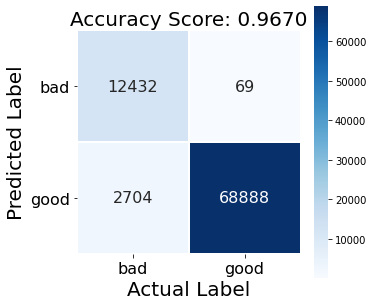

In [35]:
# Multinomial Naive Bayesian with TF-IDF

# Train the model
# (Write code here)

mnb_tfidf = MultinomialNB()
mnb_tfidf.fit(tfidf_X, labels)

# Test the mode (score, predictions, confusion matrix, classification report)
# (Write code here)
score_mnb_tfidf = mnb_tfidf.score(test_count_X, test_labels)
predictions_mnb_tfidf = mnb_tfidf.predict(test_count_X)
cmatrix_mnb_tfidf = confusion_matrix(test_labels, predictions_mnb_tfidf)
creport_mnb_tfidf = classification_report(test_labels, predictions_mnb_tfidf)

# (Keep the following lines)
print("\n### Model Built ###\n")
generate_report(cmatrix_mnb_tfidf, score_mnb_tfidf, creport_mnb_tfidf)

## Task 4c - Train and evaluate the LGS-TFIDF model
1. Create **lgs_tfidf** as a **LogisticRegression()** constructor, using the **lbfgs** *solver*
2. Use **fit** to train *lgs_tfidf* on the training data (*tfidf_X*) and training labels (*labels*)
3. Evaluate the model with the testing data (*test_tfidf_X*) and testing labels (*test_labels*):\
a. Use the **score** function in *lgs_tfidf* to calculate model accuracy; save the results as **score_lgs_tfidf**\
b. Use the **predict** function in *lgs_tfidf* to generate model predictions; save the results as **predictions_lgs_tfidf**\
c. Generate the confusion matrix with **confusion_matrix**, using the predictons and labels; save the results as **cmatrix_lgs_tfidf**\
d. Generate the classification report with **classification_report**, using the predictions and labels; save the results as **creport_lgs_tfidf**

In [38]:
# Logistic Regression with TF-IDF

# Train the model
# (Write code here)
lgs_tfidf = LogisticRegression(solver='lbfgs')
lgs_tfidf.fit(tfidf_X, labels)


# Test the mode (score, predictions, confusion matrix, classification report)
# (Write code here)
score_lgs_tfidf = lgs_tfidf.score(test_tfidf_X, test_labels)
predictions_lgs_tfidf = lgs_tfidf.predict(test_tfidf_X)
creport_lgs_tfidf = classification_report(test_labels, predictions_lgs_tfidf)
cmatrix_lgs_tfidf = confusion_matrix(test_labels, predictions_lgs_tfidf)




# (Keep the following lines)
print("\n### Model Built ###\n")
generate_report(cmatrix_lgs_tfidf, score_lgs_tfidf, creport_lgs_tfidf)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


NameError: ignored

## Task 4d - Train and evaluate the LGS-Count model
1. Create **lgs_count** as a **LogisticRegression()** constructor, using the **lbfgs** *solver*
2. Use **fit** to train *lgs_count* on the training data (*count_X*) and training labels (*labels*)
3. Evaluate the model with the testing data (*test_count_X*) and testing labels (*test_labels*):\
a. Use the **score** function in *lgs_count* to calculate model accuracy; save the results as **score_lgs_count**\
b. Use the **predict** function in *lgs_count* to generate model predictions; save the results as **predictions_lgs_count**\
c. Generate the confusion matrix with **confusion_matrix**, using the predictons and labels; save the results as **cmatrix_lgs_count**\
d. Generate the classification report with **classification_report**, using the predictions and labels; save the results as **creport_lgs_count**

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



### Model Built ###

              precision    recall  f1-score   support

         bad       0.96      0.83      0.89     15136
        good       0.96      0.99      0.98     68957

    accuracy                           0.96     84093
   macro avg       0.96      0.91      0.93     84093
weighted avg       0.96      0.96      0.96     84093



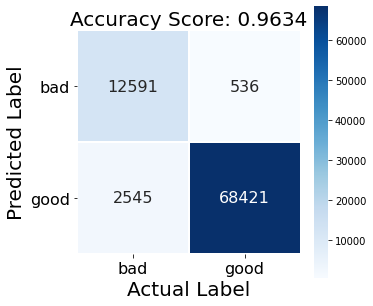

In [40]:
# Logistic Regression with Count Vectorizer

# Train the model
# (Write code here)



lgs_tfidf = LogisticRegression(solver='lbfgs')
lgs_tfidf.fit(tfidf_X, labels)


# Test the mode (score, predictions, confusion matrix, classification report)
# (Write code here)
score_lgs_count = lgs_tfidf.score(test_count_X, test_labels)
predictions_lgs_tfidf = lgs_tfidf.predict(test_count_X)
creport_lgs_count = classification_report(test_labels, predictions_lgs_tfidf)
cmatrix_lgs_count = confusion_matrix(test_labels, predictions_lgs_tfidf)




# (Keep the following lines)
print("\n### Model Built ###\n")
generate_report(cmatrix_lgs_count, score_lgs_count, creport_lgs_count)